In [1]:
# model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
  @staticmethod
  def build(width, height, depth, filters=(32, 64), latent_dim=16):

    # initialize input shape to be channels last along with channels dimension itself
    input_shape = (height, width, depth)
    chan_dim = -1

    # define input to encoder
    inputs = Input(shape=input_shape)
    x = inputs

    # loop over the number of filters
    for f in filters:
      # apply CONV => RELU => BN operations
      x = Conv2D(f, (3, 3), strides=2, padding='same')(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chan_dim)(x)

    # flatten the network and then consturct our latent vector
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, name='encoder')(x)

    # start building the decoder model which will accept output of encoder as its input
    x = Dense(np.prod(volume_size[1:]))(latent)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)

    # loop over number of filters again but this time in reverse order
    for f in filters[::-1]:
      
      # apply a Conv_transpose => RELU => BN operation
      x = Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chan_dim)(x)

    # apply a single Conv_Transpose layer used to recover the original depth of image
    x = Conv2DTranspose(depth, (3, 3), padding='same')(x)
    outputs = Activation('sigmoid', name='decoder')(x)

    # autoencoder is encoder + decoder
    autoencoder = Model(inputs, outputs, name='autoencoder')

    return autoencoder

In [2]:
# training autoencoders

import matplotlib
matplotlib.use('Agg')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Function to help visualize predictions made by unsupervised autoencoder 
def visualize_prediction(decode, gt, samples=10):
  # initialize list of output images
  outputs = None

  # loop over our number of output samples
  for i in range(0, samples):
    # grab original image and reconstructed image
    original = (gt[i]*255).astype('uint8')
    recon = (decode[i]*255).astype('uint8')

    # stack original and reconstructed images side by side
    output = np.hstack([original, recon])

    # if the output array is empty, initialize it as the current side-by-side image display
    if outputs is None:
      outputs = output

    # otherwise vertically stack the output
    else:
      outputs = np.vstack([outputs, output])

  return outputs

# arguments
model_name = 'output/autoencoder.model'         # path to our output trained autoencoder
visu = "recon_vis.png"
plot = "plot.png"
epochs = 20
init_lr = 1e-3
batch_size = 32

# load mnist dataset
print('[INFO] loading MNIST dataset...')
((trainX, _), (testX, _)) = mnist.load_data()

# add channel dimension to every image in dataset and scale pixel intensities to range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# construct our Conv autoencoder
print('[INFO] building autoencoder...')
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
autoencoder.compile(loss='mse', optimizer=opt)

# train convolution autoencoder
H=autoencoder.fit(trainX, trainX, validation_data=(testX, testX), epochs=epochs, 
                    batch_size=batch_size)

# use the convolution auto encoder to make the predictions on the testing images, construct the 
# visualizations and save it to disk
decoded = autoencoder.predict(testX)
vis = visualize_prediction(decoded, testX)
cv.imwrite(visu, vis)

# construct a plot that plots and saves training history
N = np.arange(0, epochs)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='validation_loss')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(plot)

# serialize the autoencoder model to disk
print('[INFO] saving autoencoder')
autoencoder.save(model_name, save_format='h5')

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step
[INFO] building autoencoder...
Epoch 1/20
1875/1875 [==============================] - 19s 5ms/step - loss: 0.0187 - val_loss: 0.0106
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 9/20
1875/1875 [==============================] -

In [3]:
# indexing images

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import numpy as np
import pickle

model_path = 'output/autoencoder.model'   # path to trained autoencoder model
index_path = 'output/index.pickle'        # path to output features index file

# load mnist dataset
print('[INFO] loading MNIST dataset...')
((trainX, _), (testX, _)) = mnist.load_data()

# add channel dimension to every image in dataset and scale pixel intensities to range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
trainX = trainX.astype('float32')/255.0

# load encoder model from disk
print('[INFO] loading autoencoder model...')
autoencoder = load_model(model_path)

# create the auto encoder model which consists of just the encoder portion of model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

# quantify the contents of our input images using encoder
print('[INFO] encoding images...')
features = encoder.predict(trainX)

# construct a dictionary that maps index of MNIST training image to its corresponding latent-space
# representation
indexes = list(range(0, trainX.shape[0]))
data = {'indexes': indexes, 'features' : features}

# write data dictionary to disk
print('[INFO] Saving index...')
f = open(index_path, 'wb')
f.write(pickle.dumps(data))
f.close()

[INFO] loading MNIST dataset...
[INFO] loading autoencoder model...
[INFO] encoding images...
[INFO] Saving index...


[INFO] loading MNIST dataset...
[INFO] loading autoencoder model...
[INFO] testing encoding images...


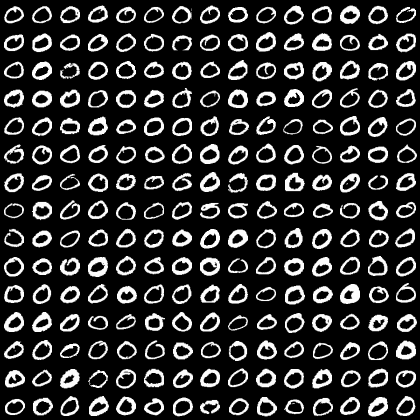

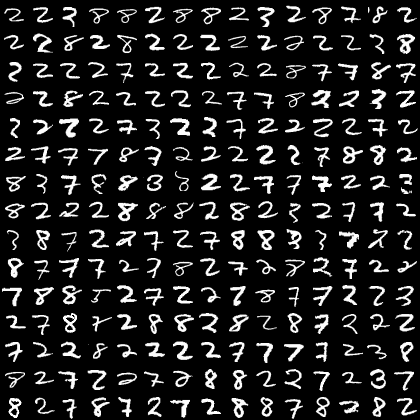

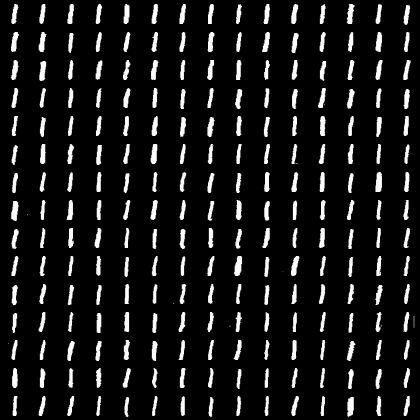

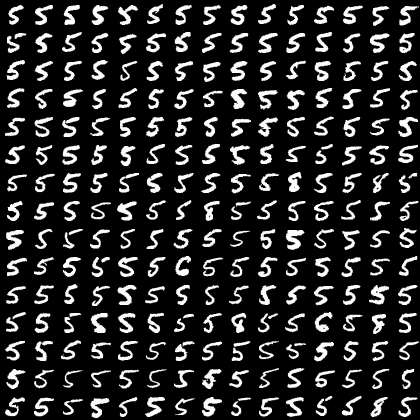

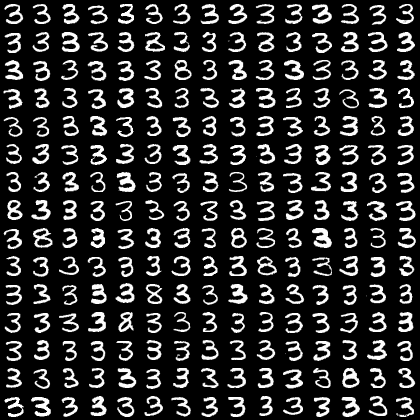

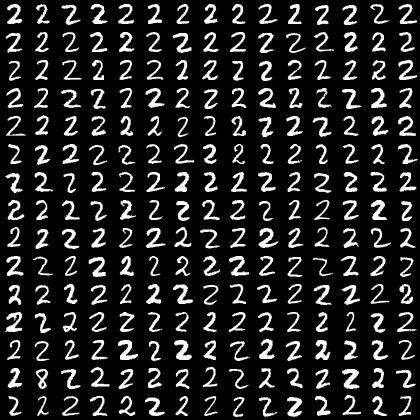

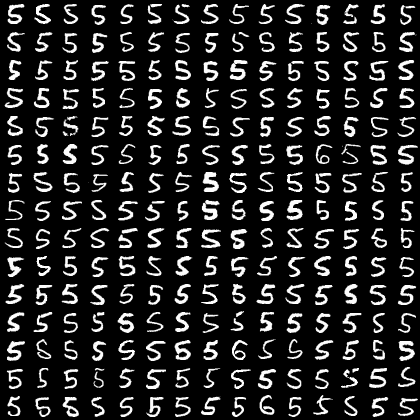

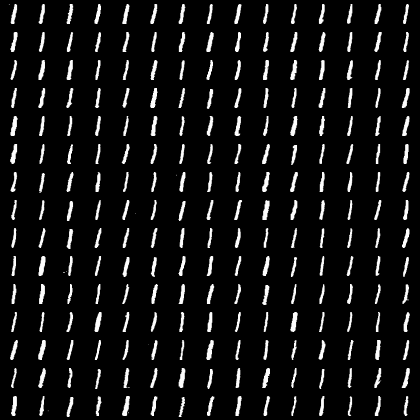

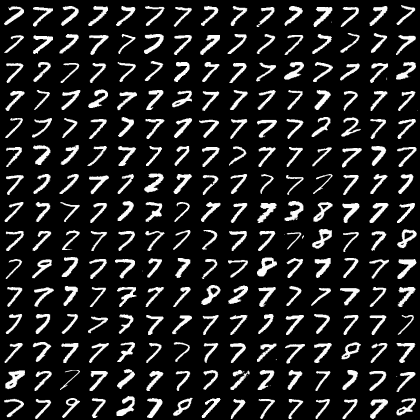

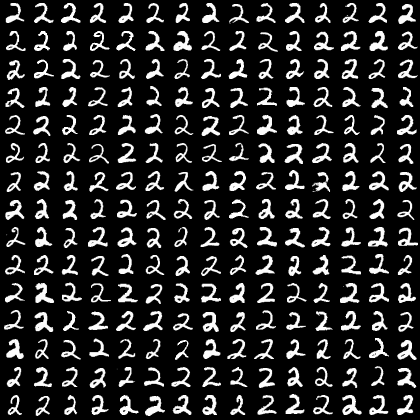

In [5]:
# image Retrival
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from imutils import build_montages
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pickle

# define distance function
def euclidean(a, b):
  # compute and return  euclidean distance between two vectors
  return np.linalg.norm(a-b)

# define searching function
def perform_search(query_features, index, max_results=64):
  # initialize list of results
  results = []

  # loop over index
  for i in range(0, len(index['features'])):
    # compute euclidean distance between query features, and features of current image in our index
    # then update results list with a 2-tuple consisting of computed distance and index of image
    d = euclidean(query_features, index['features'][i])
    results.append((d, i))

  # sort the results and grab the top ones
  results = sorted(results)[:max_results]

  return results

# arguments
model_path = 'output/autoencoder.model'
index_path = 'output/index.pickle'
samples = 10

# load mnist dataset
print('[INFO] loading MNIST dataset...')
((trainX, _), (testX, _)) = mnist.load_data()

# add channel dimension to every image in dataset and scale pixel intensities to range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# load encoder model from disk
print('[INFO] loading autoencoder model...')
autoencoder = load_model(model_path)
index = pickle.loads(open(index_path, 'rb').read())

# create the auto encoder model which consists of just the encoder portion of model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

# quantify the contents of our input images using encoder
print('[INFO] testing encoding images...')
features = encoder.predict(testX)

# randomly sample a set of testing query images
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=samples, replace=False)

# loop over testing indexes
for i in queryIdxs:
  # take features for the current images, find all similar images in dataset and initialize list
  # of resulting images
  query_features = features[i]
  results = perform_search(query_features, index, max_results=225)
  images = []

  # loop over the results
  for (d, j) in results:
    # grab the result image, conver it back to [0, 255], and update image list
    image = (trainX[j]*255).astype('uint8')
    image = np.dstack([image]*3)
    images.append(image)

  # display the query image
  query = (testX[i]*255).astype('uint8')
  cv2_imshow(query)

  # build a montage from results and display it
  montage = build_montages(images, (28, 28), (15, 15))[0]
  cv2_imshow(montage)